# 🧭 Comprehensive EDA Tutorial — Reusable Functions + Detailed Interpretations

This notebook analyzes `loan_predication.csv` and provides **reusable functions** for each EDA step.  
All commentary is in **English only**, with **clear guidance on how to interpret values** (e.g., positive/negative correlations, equal bars in charts, small differences) and **precise plots** that display values.

## Table of Contents
1. Parameters & Setup  
2. Utility Helpers (formatting, labeling)  
3. Data Loading  
4. Dataset Overview  
5. Missing Values  
6. Duplicates  
7. Univariate Analysis — Numerical  
8. Univariate Analysis — Categorical  
9. Correlation Analysis  
10. Bivariate Analysis with Target  
11. Key Insights & Next Steps

## 1) Parameters & Setup

* Edit `DATASET_PATH` to point to your CSV.  
* Uses only **matplotlib** for plotting (no seaborn).  
* Each plot is a **separate figure**, with default styles and labels added for clarity.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 130)

DATASET_PATH = "loan_predication.csv"  # Change this if your file is elsewhere

In [4]:
df = pd.read_csv(DATASET_PATH)

## 2) Utility Helpers

Helper functions for consistent labeling and formatting:
- `annotate_bars(ax, values=None, fmt="{:.0f}")`: places value labels on top of bars.
- `add_mean_median_lines(ax, data)`: overlays vertical lines (mean/median) on histograms.
- `iqr_outliers(s)`: computes outlier counts using the IQR rule.

In [5]:
def annotate_bars(ax, values=None, fmt="{:.0f}", perc=False):
    """Add labels on top of bar patches in an Axes.
    If `values` is provided, it must align with bars order.
    Set `perc=True` to format as percentages.
    """
    for i, p in enumerate(ax.patches):
        height = p.get_height()
        if np.isnan(height):
            continue
        txt = None
        if values is not None:
            v = values[i]
            txt = (fmt.format(v * 100) + "%") if perc else fmt.format(v)
        else:
            txt = (fmt.format(height * 100) + "%") if perc else fmt.format(height)
        ax.annotate(txt, (p.get_x() + p.get_width()/2.0, height),
                    ha="center", va="bottom", xytext=(0, 2), textcoords="offset points")

def add_mean_median_lines(ax, data):
    """Plot vertical lines for mean and median on the current Axes and return their values."""
    mean_val = np.nanmean(data)
    median_val = np.nanmedian(data)
    ax.axvline(mean_val, linestyle="--", linewidth=1)
    ax.axvline(median_val, linestyle="-.", linewidth=1)
    ax.legend([f"Mean = {mean_val:.3f}", f"Median = {median_val:.3f}"], loc="best")
    return mean_val, median_val

def iqr_outliers(s: pd.Series):
    """Return outlier counts based on IQR rule (Q1 - 1.5*IQR, Q3 + 1.5*IQR)."""
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    below = (s < lower).sum()
    above = (s > upper).sum()
    return {"q1": q1, "q3": q3, "iqr": iqr, "lower": lower, "upper": upper, "below": below, "above": above}

## 3) Data Loading

`load_dataset(path)`:
- Reads the CSV into a DataFrame.
- Prints shape (rows, columns) and returns the DataFrame.
- Use it across different datasets for consistent loading.

In [6]:
def load_dataset(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    print("Shape (rows, columns):", df.shape)
    return df

df = load_dataset(DATASET_PATH)
df.head()

Shape (rows, columns): (614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## 4) Dataset Overview

`overview(df)`:
- Shows `info()` (column names, dtypes, non-null counts).
- Shows `describe()` for **numeric** and **categorical** columns.

**How to read it:**
- Numeric `mean` and `std`: high `std` → large variability; compare `mean` vs `median` (from the hist step) for skewness hints.
- Categorical `top` & `freq`: if one category dominates (e.g., >70%), expect **class imbalance** issues.

In [26]:
def overview(df: pd.DataFrame):
    print("=== DataFrame.info() ===")
    df.info()
    print("\n=== Numeric describe() ===")
    display(df.describe(include=[np.number]).T)
    print("\n=== Categorical describe() ===")
    display(df.describe(include=['object']).T)

overview(df)

=== DataFrame.info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB

=== Numeric describe() ===


,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,592.0,146.412162,85.587325,9.0,100.0,128.0,168.00,700.0
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.00,480.0
Credit_History,564.0,0.842199,0.364878,0.0,1.0,1.0,1.00,1.0



=== Categorical describe() ===


,count,unique,top,freq
Loan_ID,614,614,LP001002,1
Gender,601,2,Male,489
Married,611,2,Yes,398
Dependents,599,4,0,345
Education,614,2,Graduate,480
Self_Employed,582,2,No,500
Property_Area,614,3,Semiurban,233
Loan_Status,614,2,Y,422


## 5) Missing Values

`missing_values(df)`:
- Table with **count** and **ratio** per column.
- Bar chart with labels for columns having missing values.

**Interpretation guide:**
- `ratio >= 0.30`: very high → consider dropping the column or advanced imputation.
- `0.05 ≤ ratio < 0.30`: moderate → impute (median/most-frequent) or model-based imputation.
- `ratio < 0.05`: low → simple imputation is usually fine.
- If bars are **equal or near-zero**, missingness is evenly distributed or negligible; focus elsewhere.

,missing_count,missing_ratio
Credit_History,50,0.081433
Self_Employed,32,0.052117
LoanAmount,22,0.035831
Dependents,15,0.024430
Loan_Amount_Term,14,0.022801
Gender,13,0.021173
Married,3,0.004886


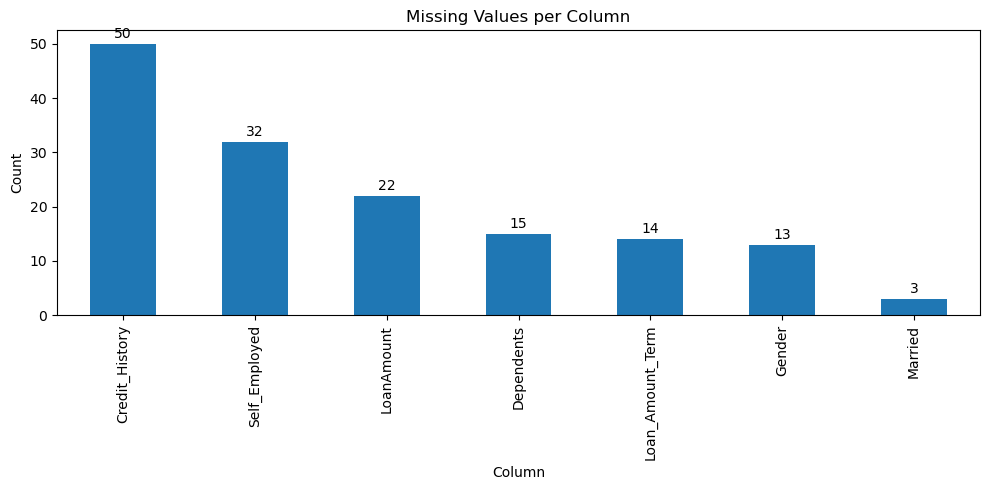

In [7]:
def missing_values(df: pd.DataFrame):
    miss_count = df.isna().sum().sort_values(ascending=False)
    miss_ratio = (miss_count / len(df)).sort_values(ascending=False)
    table = pd.DataFrame({"missing_count": miss_count, "missing_ratio": miss_ratio})
    display(table[table["missing_count"] > 0])

    plt.figure(figsize=(10, 5))
    ax = miss_count[miss_count > 0].plot(kind="bar")
    plt.title("Missing Values per Column")
    plt.xlabel("Column")
    plt.ylabel("Count")
    annotate_bars(ax)
    plt.tight_layout()
    plt.show()

missing_values(df)

## 6) Duplicates

`duplicates(df)`:
- Prints total duplicate rows and previews a sample.

**Interpretation guide:**
- Many duplicates can bias training and inflate performance metrics.  
- Remove duplicates unless they are **meaningful** (e.g., legitimate repeated events).

In [8]:
def duplicates(df: pd.DataFrame, sample_n=5):
    dup = df.duplicated()
    count = dup.sum()
    print("Duplicate rows:", count)
    if count > 0:
        display(df[dup].head(sample_n))

duplicates(df)

Duplicate rows: 0


## 7) Univariate Analysis — Numerical

`univariate_numeric(df)`:
- For each numeric column: compute basic stats, **skewness**, IQR outliers; draw a histogram with **mean/median lines**.
- **Precise reading**: mean vs median gap indicates skew; IQR outliers indicate heavy tails.

**What equal-looking bars mean:** uniform-like distribution; low information density unless combined with other features.  
**When tails are heavy:** consider transformations (log, box-cox) or robust models.


=== ApplicantIncome ===
count: 614 unique: 505
mean: 5403.459283387622 std: 6109.041673387174 min: 150 25%: 2877.5 50%: 3812.5 75%: 5795.0 max: 81000
skew: 6.539513113994625 kurtosis: 60.54067593369113
IQR outliers → below: 0 above: 50 | bounds: [-1498.750, 10171.250]


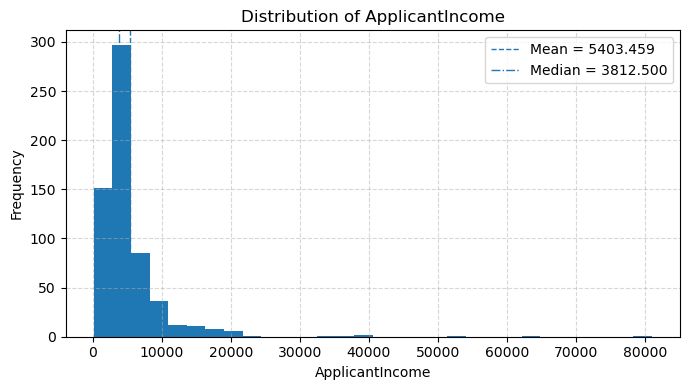


=== CoapplicantIncome ===
count: 614 unique: 287
mean: 1621.2457980271008 std: 2926.2483692241917 min: 0.0 25%: 0.0 50%: 1188.5 75%: 2297.25 max: 41667.0
skew: 7.491531216657306 kurtosis: 84.95638421103374
IQR outliers → below: 0 above: 18 | bounds: [-3445.875, 5743.125]


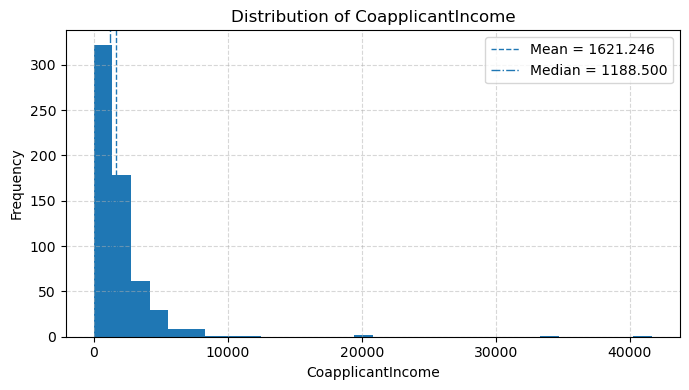


=== LoanAmount ===
count: 592 unique: 203
mean: 146.41216216216216 std: 85.58732523570545 min: 9.0 25%: 100.0 50%: 128.0 75%: 168.0 max: 700.0
skew: 2.677551679256058 kurtosis: 10.40153349029415
IQR outliers → below: 0 above: 39 | bounds: [-2.000, 270.000]


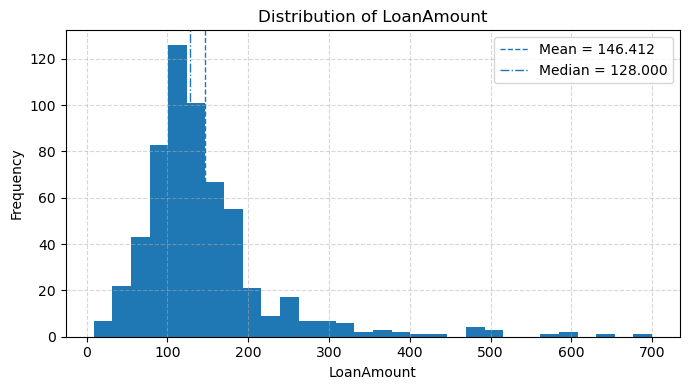


=== Loan_Amount_Term ===
count: 600 unique: 10
mean: 342.0 std: 65.12040985461256 min: 12.0 25%: 360.0 50%: 360.0 75%: 360.0 max: 480.0
skew: -2.362414124216269 kurtosis: 6.673473692814259
IQR outliers → below: 73 above: 15 | bounds: [360.000, 360.000]


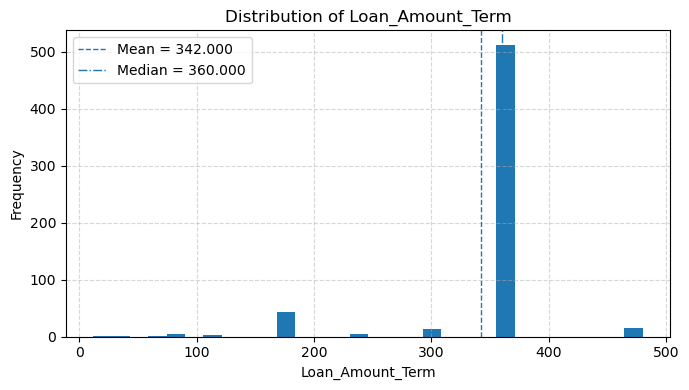


=== Credit_History ===
count: 564 unique: 2
mean: 0.8421985815602837 std: 0.3648783192364049 min: 0.0 25%: 1.0 50%: 1.0 75%: 1.0 max: 1.0
skew: -1.8823610612186696 kurtosis: 1.5487626683496147
IQR outliers → below: 89 above: 0 | bounds: [1.000, 1.000]


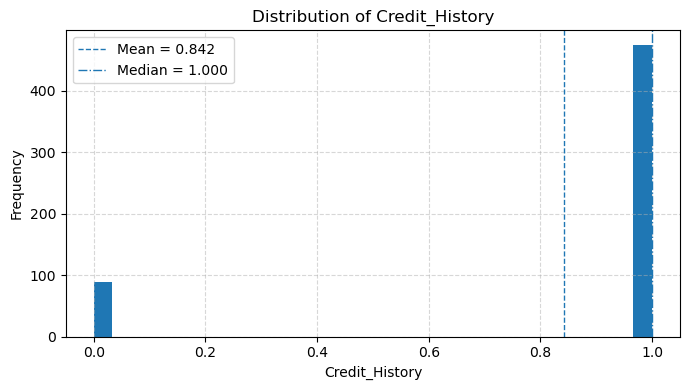

In [9]:
def univariate_numeric(df: pd.DataFrame, bins=30):
    num_cols = df.select_dtypes(include=[np.number]).columns
    if len(num_cols) == 0:
        print("No numeric columns found.")
        return

    for col in num_cols:
        s = df[col].dropna()
        print(f"\n=== {col} ===")
        print("count:", s.size, "unique:", s.nunique())
        print("mean:", s.mean(), "std:", s.std(), "min:", s.min(), "25%:", s.quantile(0.25),
              "50%:", s.median(), "75%:", s.quantile(0.75), "max:", s.max())
        print("skew:", s.skew(), "kurtosis:", s.kurt())

        out = iqr_outliers(s)
        print("IQR outliers → below:", out["below"], "above:", out["above"],
              "| bounds:", f"[{out['lower']:.3f}, {out['upper']:.3f}]")

        plt.figure(figsize=(7, 4))
        ax = plt.gca()
        ax.hist(s, bins=bins)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        mean_val, median_val = add_mean_median_lines(ax, s.values)
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.tight_layout()
        plt.show()

univariate_numeric(df)

## 8) Univariate Analysis — Categorical

`univariate_categorical(df)`:
- For each categorical column: compute counts and **percentages**; plot a bar chart with **count labels**.

**Interpretation guide:**
- If one category >> others (e.g., >70%), the variable is **imbalanced** → may need **re-sampling** or **weighting**.
- If bars are equal (or close), the variable is balanced; this can be helpful for modeling.
- Small visible differences may still be statistically relevant; check with a chi-square test later if needed.


=== Loan_ID ===


,count,percent
LP001002,1,0.001629
LP002328,1,0.001629
LP002305,1,0.001629
LP002308,1,0.001629
LP002314,1,0.001629
LP002315,1,0.001629
LP002317,1,0.001629
LP002318,1,0.001629
LP002319,1,0.001629
LP002332,1,0.001629


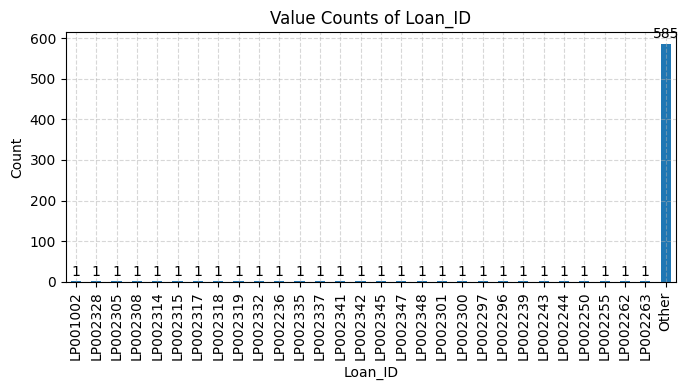


=== Gender ===


,count,percent
Gender,,
Male,489,0.796417
Female,112,0.182410
NaN,13,0.021173


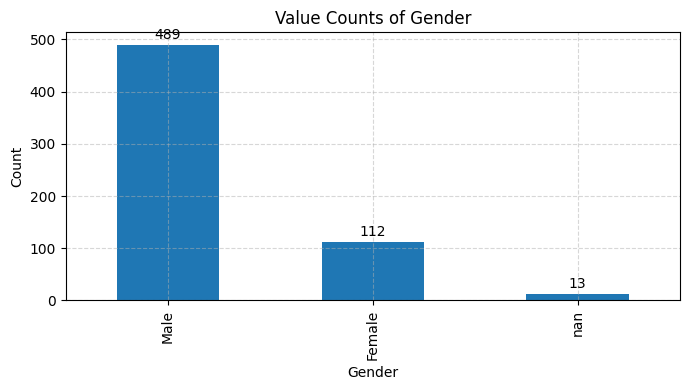


=== Married ===


,count,percent
Married,,
Yes,398,0.648208
No,213,0.346906
NaN,3,0.004886


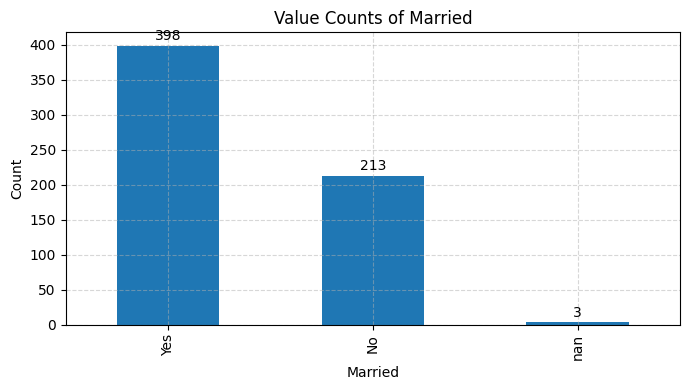


=== Dependents ===


,count,percent
Dependents,,
0,345,0.561889
1,102,0.166124
2,101,0.164495
3+,51,0.083062
NaN,15,0.024430


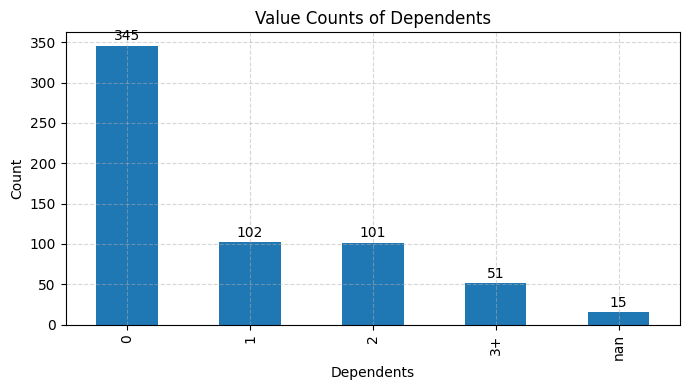


=== Education ===


,count,percent
Education,,
Graduate,480,0.781759
Not Graduate,134,0.218241


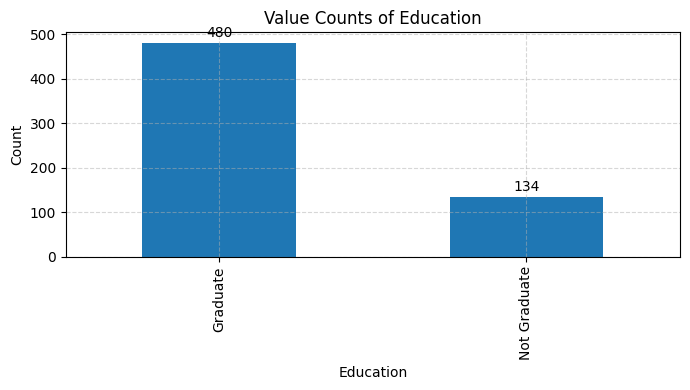


=== Self_Employed ===


,count,percent
Self_Employed,,
No,500,0.814332
Yes,82,0.133550
NaN,32,0.052117


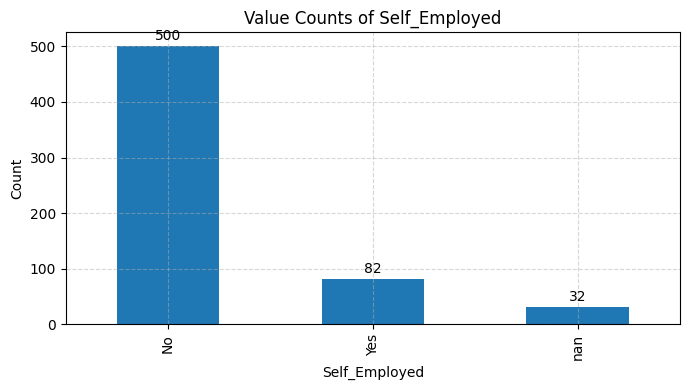


=== Property_Area ===


,count,percent
Property_Area,,
Semiurban,233,0.379479
Urban,202,0.328990
Rural,179,0.291531


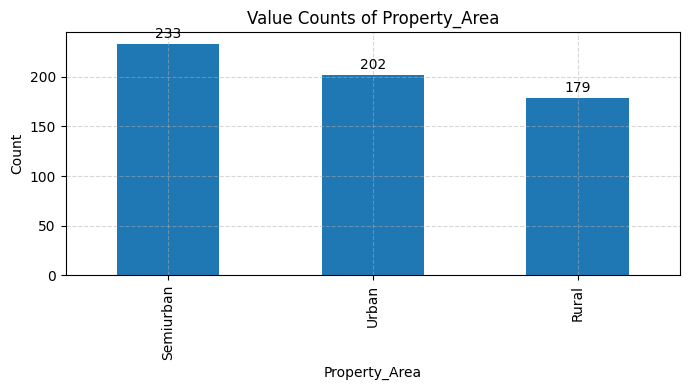


=== Loan_Status ===


,count,percent
Loan_Status,,
Y,422,0.687296
N,192,0.312704


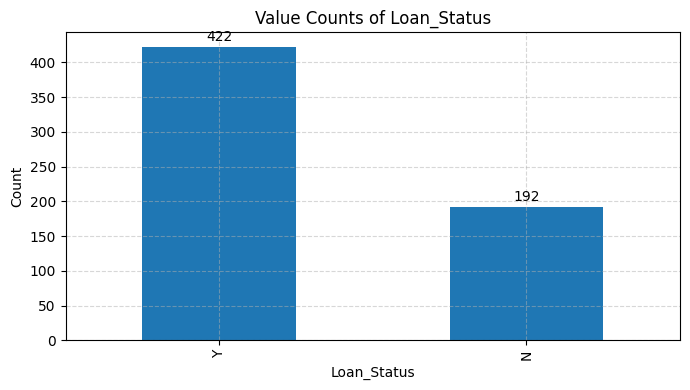

In [30]:
def univariate_categorical(df: pd.DataFrame, max_categories=30):
    cat_cols = df.select_dtypes(include=['object']).columns
    if len(cat_cols) == 0:
        print("No categorical columns found.")
        return

    for col in cat_cols:
        vc = df[col].value_counts(dropna=False)
        if len(vc) > max_categories:
            # Aggregate tail into 'Other'
            top = vc.iloc[:max_categories-1]
            other = pd.Series({"Other": vc.iloc[max_categories-1:].sum()})
            vc = pd.concat([top, other])

        perc = vc / vc.sum()

        print(f"\n=== {col} ===")
        display(pd.DataFrame({"count": vc, "percent": perc}))

        plt.figure(figsize=(7, 4))
        ax = vc.plot(kind="bar")
        plt.title(f"Value Counts of {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        annotate_bars(ax)
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.tight_layout()
        plt.show()

univariate_categorical(df)

## 9) Correlation Analysis

`correlation_analysis(df, target=None)`:
- Computes Pearson correlation for numeric columns and displays a heatmap (default colormap).
- If `target` provided and numeric, prints the **sorted correlation with target**.

**Interpretation guide:**
- **Positive (~+1):** features increase together.
- **Negative (~-1):** one increases while the other decreases.
- **Near 0:** little linear relation (though non-linear effects may exist).
- Strong absolute correlation (e.g., ≥0.8) → potential **multicollinearity**; consider dropping or combining.

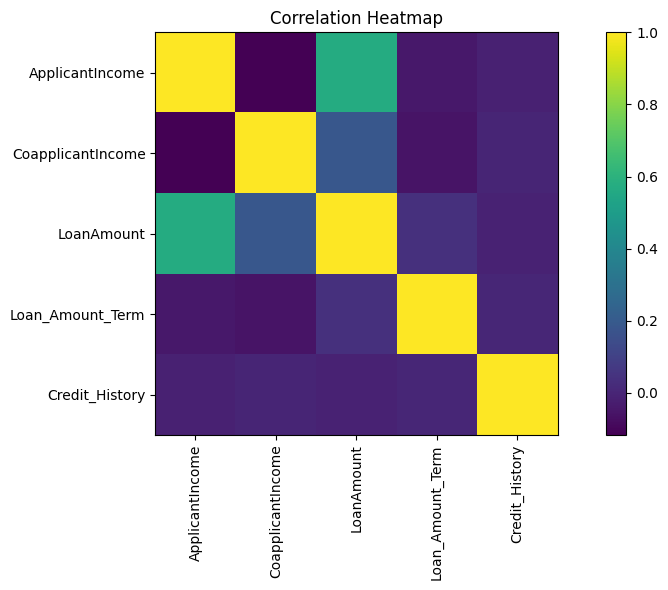

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
ApplicantIncome,1.000000,-0.116605,0.570909,-0.045306,-0.014715
CoapplicantIncome,-0.116605,1.000000,0.188619,-0.059878,-0.002056
LoanAmount,0.570909,0.188619,1.000000,0.039447,-0.008433
Loan_Amount_Term,-0.045306,-0.059878,0.039447,1.000000,0.001470
Credit_History,-0.014715,-0.002056,-0.008433,0.001470,1.000000


In [31]:
def correlation_analysis(df: pd.DataFrame, target: str | None = None):
    corr = df.corr(numeric_only=True)
    plt.figure(figsize=(10, 6))
    plt.imshow(corr, interpolation="nearest")
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.title("Correlation Heatmap")
    plt.tight_layout()
    plt.show()

    display(corr)

    if target is not None and target in corr.columns:
        print(f"\n=== Correlation with target: {target} ===")
        display(corr[target].dropna().sort_values(ascending=False))

# Attempt to detect a likely target
target_guess = "Loan_Status" if "Loan_Status" in df.columns else None
correlation_analysis(df, target=target_guess)

## 10) Bivariate Analysis with Target

`bivariate_with_target(df, target)`:
- **Numeric vs Target (categorical)**: bar of group means (per class). If bars are similar → weak separation; big gaps → potentially predictive.
- **Categorical vs Target (categorical)**: normalized stacked bars showing **percentage distribution** per category.

**Interpretation guide:**
- Equal or near-equal bars across target classes → feature likely weak for discrimination.  
- Small differences may still matter when combined with other features (check SHAP/feature importance later).  
- Always consider sample size; tiny groups can give misleading patterns.

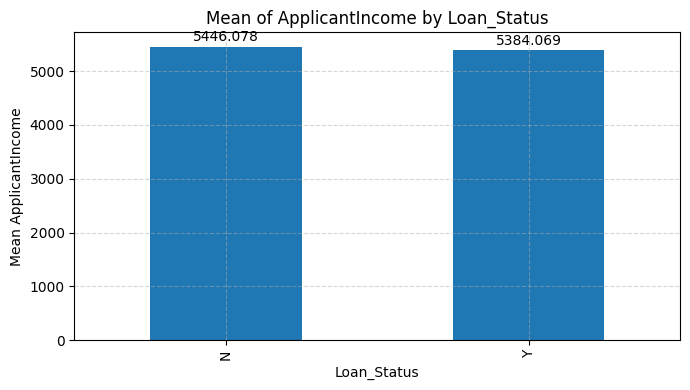

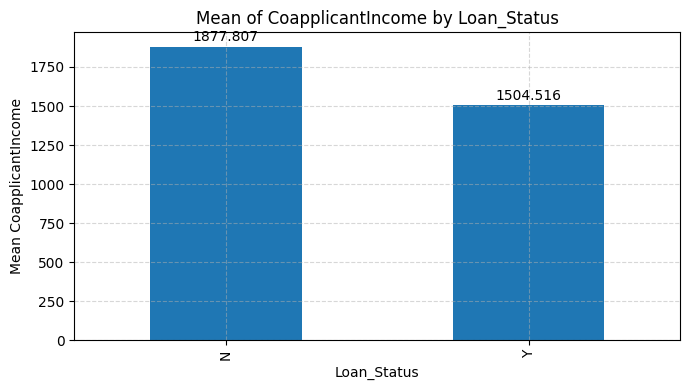

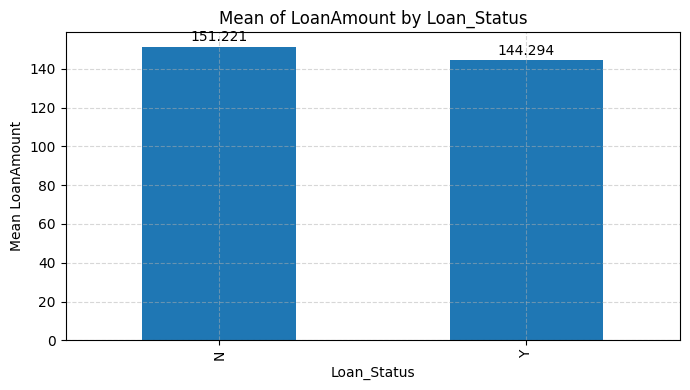

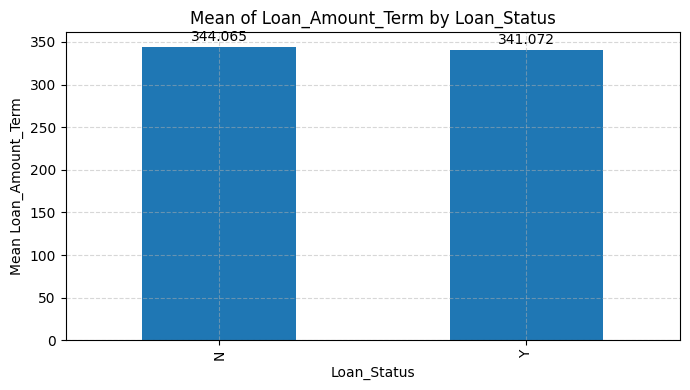

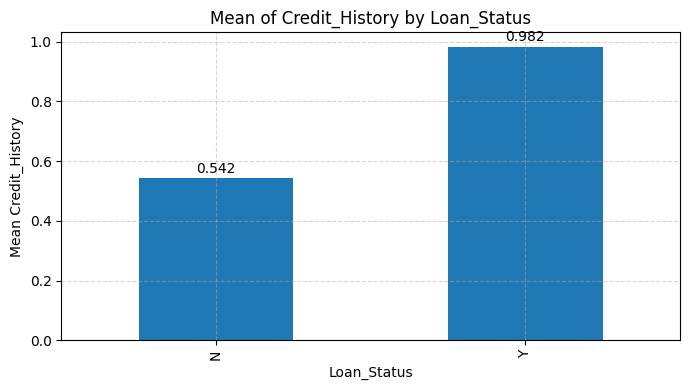

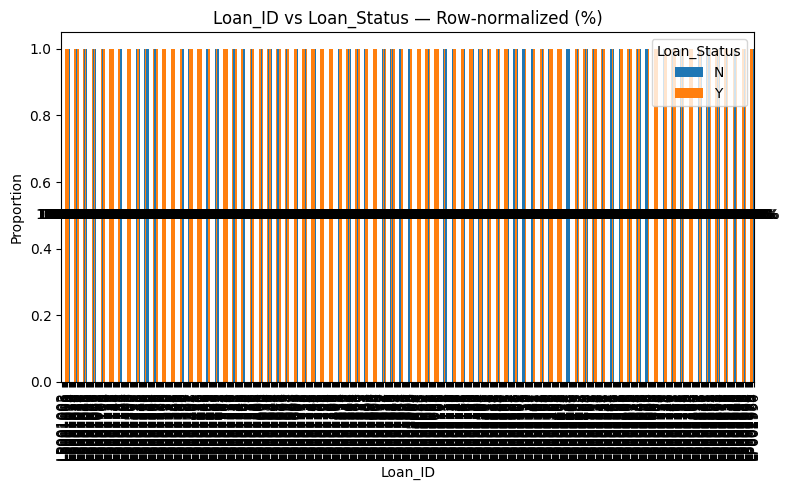

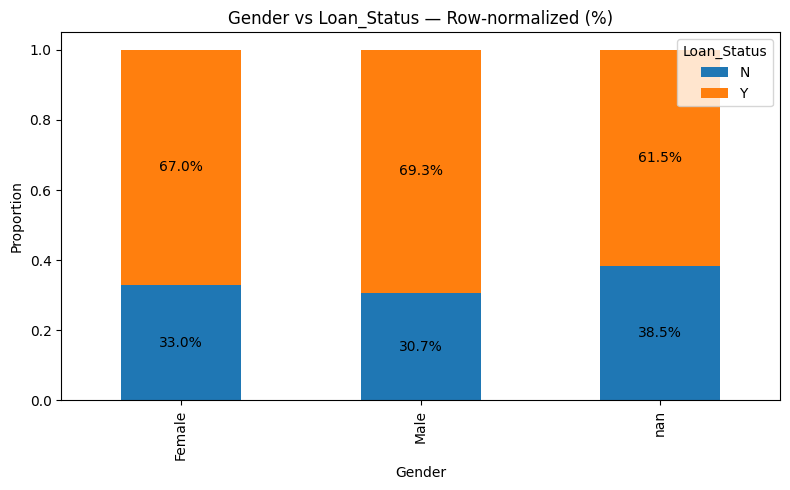

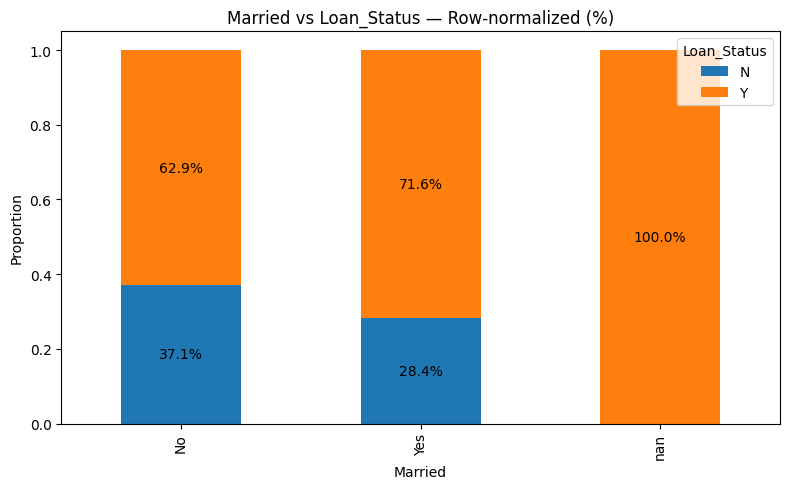

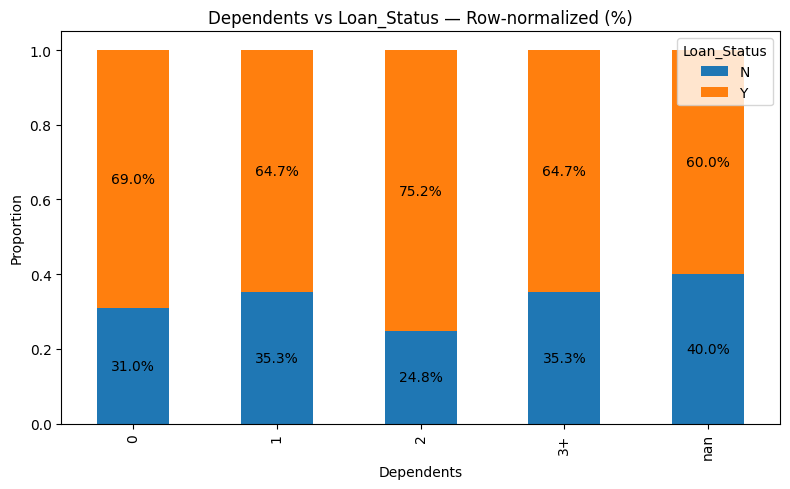

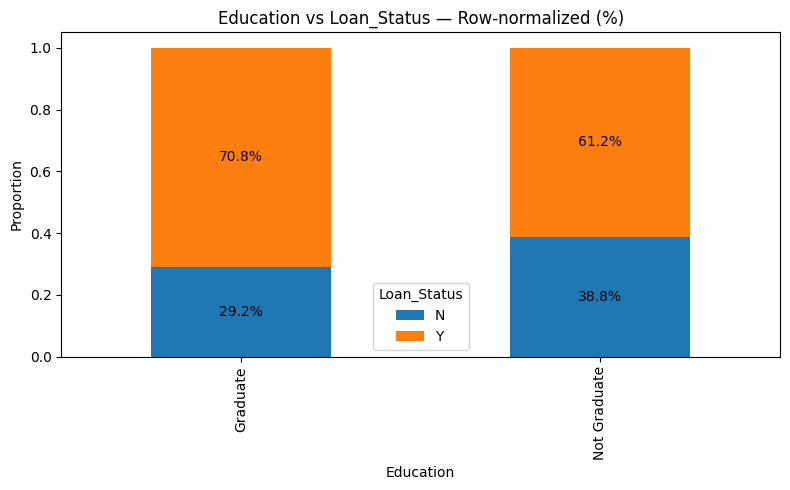

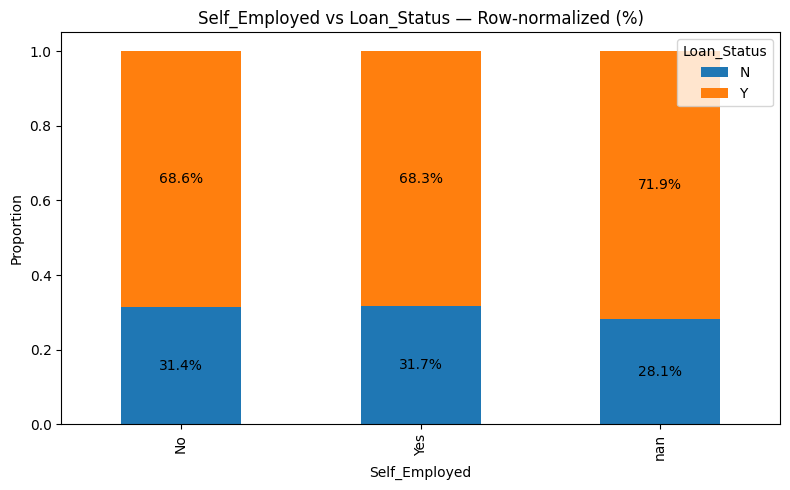

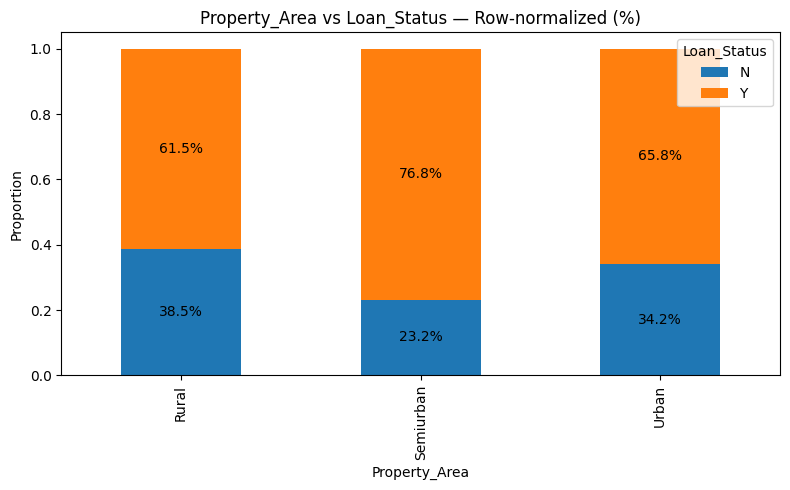

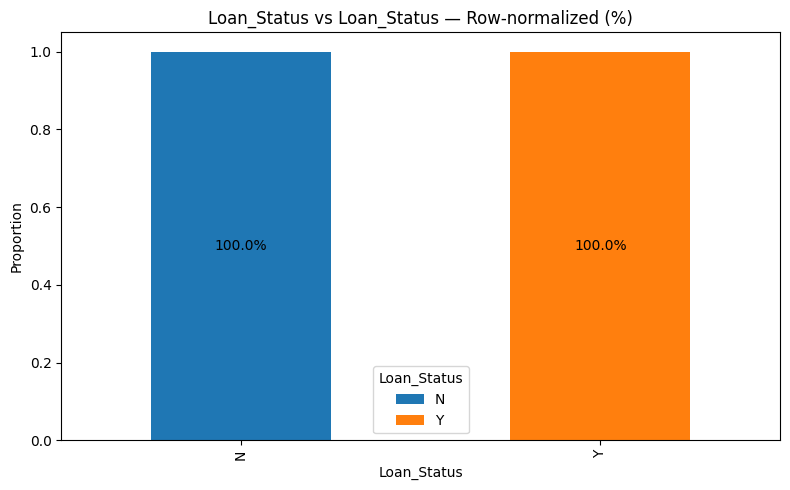

In [32]:
def bivariate_with_target(df: pd.DataFrame, target: str):
    if target is None or target not in df.columns:
        print("No valid target column provided.")
        return

    # Numeric features: mean by target
    num_cols = df.select_dtypes(include=[np.number]).columns
    for col in num_cols:
        grouped = df.groupby(target, dropna=False)[col].mean()
        plt.figure(figsize=(7, 4))
        ax = grouped.plot(kind="bar")
        plt.title(f"Mean of {col} by {target}")
        plt.ylabel(f"Mean {col}")
        annotate_bars(ax, values=grouped.values, fmt="{:.3f}")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.tight_layout()
        plt.show()

    # Categorical features: normalized stacked bar (percent by row)
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        ctab = pd.crosstab(df[col], df[target], dropna=False, normalize='index')
        ax = ctab.plot(kind='bar', stacked=True, figsize=(8, 5))
        plt.title(f"{col} vs {target} — Row-normalized (%)")
        plt.ylabel("Proportion")
        # annotate each bar segment with percentage
        for p in ax.patches:
            height = p.get_height()
            if height > 0.02:  # annotate only if visibly large
                ax.annotate(f"{height*100:.1f}%",
                            (p.get_x() + p.get_width()/2.0, p.get_y() + height/2.0),
                            ha="center", va="center")
        plt.tight_layout()
        plt.show()

bivariate_with_target(df, target_guess)

In [36]:
from modules import eda_toolkit as eda

In [37]:
df=eda.load_dataset("../datasets/loan_predication/loan_predication.csv")

Shape (rows, columns): (614, 13)


In [38]:
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [39]:
df.head()


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
